In [15]:
import evrp
import random
import math

path="../evrp-benchmark-set/"

In [7]:
instances=evrp.read_in_all_instances(path)
print(list(instances.keys()))

['X-n573-k30', 'X-n749-k98', 'X-n1001-k43', 'X-n214-k11', 'X-n143-k7', 'X-n819-k171', 'E-n101-k8', 'X-n916-k207', 'E-n23-k3', 'E-n51-k5', 'X-n351-k40', 'E-n33-k4', 'E-n76-k7', 'E-n30-k3', 'X-n685-k75', 'X-n459-k26', 'E-n22-k4']


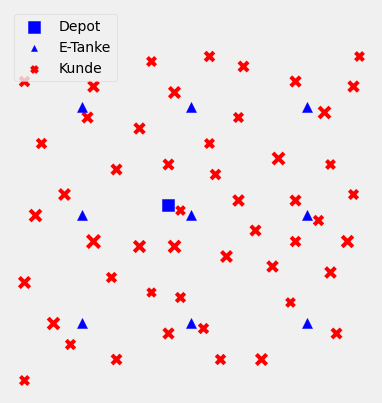

In [9]:
inst=instances['E-n51-k5']
evrp.show(inst)

## Genetischer Algorithmus

In [105]:
import time

def select(population,scores,t=3):
    N=len(population)
    choice=random.sample(range(N),t)
    best=math.inf
    best_index=None
    for index in choice:
        if scores[index]<best:
            best=scores[index]
            best_index=index
    return population[index]

def list_to_tour_vector(tour):
    tour_vector=[]
    for i,vehicle_tour in enumerate(tour):
        tour_vector.extend(vehicle_tour)
        tour_vector.append(-i-1)
    if len(tour_vector)>0:
        del tour_vector[-1]
    return tour_vector

def strip_stations(tour,instance):
    new_tour=[]
    for vehicle_tour in tour:
        new_vehicle_tour=[stop for stop in vehicle_tour if stop in instance.customers]
        new_tour.append(new_vehicle_tour)
    return new_tour

def reset_stations(tour,instance):
    new_tour=strip_stations(tour,instance)
    evrp.fix_range(new_tour,instance)
    return new_tour

def swap_mutation(tour_vector):
    pos1,pos2=random.randint(0,len(tour_vector)-1),random.randint(0,len(tour_vector)-1)
    tour_vector[pos1],tour_vector[pos2]=tour_vector[pos2],tour_vector[pos1]

RESET_RATE=0.25
MUTATE_NUM=3
MUTATION_RATE=0.25

def mutate(tour_vector,instance):
    mutation=tour_vector.copy()
    if random.random()<=RESET_RATE:
        reset_tour=reset_stations(evrp.tour_vector_to_list(tour_vector),instance)
        return list_to_tour_vector(reset_tour)
    for _ in range(MUTATE_NUM):
        if random.random()<=MUTATION_RATE:
            swap_mutation(mutation)
    return mutation

def find_missing_and_doubles(child,instance):
    doubles=[]
    counted=[instance.depot]
    for stop in child:
        if stop in instance.customers:
            if stop in counted and stop!=instance.depot:
                doubles.append(stop)
            else:
                counted.append(stop)
    missing=[customer for customer in instance.customers if not customer in counted]
    return missing,doubles


def best_insert_single_missing(tour,missing,instance,tries=10):
    best=math.inf
    best_pos=None
    for _ in range(tries):
        vehicle_tour=random.choice(tour)
        pos=random.randint(0,len(vehicle_tour))
        vehicle_tour.insert(pos,missing)
        score=evrp.soft_objective_function([vehicle_tour],instance)
        if score<best:
            best=score
            best_pos=(vehicle_tour,pos)
        del vehicle_tour[pos]
    vehicle_tour,pos=best_pos
    vehicle_tour.insert(pos,missing)

def best_insert_all_missing(tour,missings,instance,tries=10):
    #random.shuffle(missings)
    for m in missings:
        best_insert_single_missing(tour,m,instance,tries=tries)
        
def strip_doubles(child,p,q,doubles):
    first=[stop for stop in child[:p] if not stop in doubles]
    middle=child[p:q]
    second=[stop for stop in child[q:] if not stop in doubles]
    first.extend(middle)
    first.extend(second)
    return first
    
def fix(child,p,q,instance):
    missings,doubles=find_missing_and_doubles(child,instance)
    child=strip_doubles(child,p,q,doubles)
    child_tour=evrp.tour_vector_to_list(child)
    best_insert_all_missing(child_tour,missings,instance,tries=10)
    return list_to_tour_vector(child_tour)
    
def crossover(parent1,parent2,instance):
    ### parents don't need to have the same length!
    max_len=min(len(parent1),len(parent2))
    p=random.randint(0,max_len-1)
    q=random.randint(p+1,max_len)
    child=parent1.copy()
    child[p:q]=parent2[p:q]
    child=fix(child,p,q,instance)
    return child

def compute_initial_population(instance,N):
    population=[]
    for _ in range(N):
        tour=evrp.rnd_tour(instance)
        evrp.fix_range(tour,instance)
        population.append(list_to_tour_vector(tour))
    return population
        
def compute_scores(population,instance):
    scores=[]
    for tour_vector in population:
        tour=evrp.tour_vector_to_list(tour_vector)
        score=evrp.soft_objective_function(tour,instance)
        scores.append(score)
    return scores

def update_best(best,best_animal,scores,population):
    for score,animal in zip(scores,population):
        if score<best:
            best=score
            best_animal=animal
    return best,best_animal

def genetic_algo(instance,N,time_budget,record=False):
    start=time.time()
    population=compute_initial_population(instance,N)
    best=math.inf
    best_animal=None
    scores_over_generations=[]
    generation=0
    while time.time()-start<time_budget:
        generation+=1
        scores=compute_scores(population,instance)
        if record:
            scores_over_generations.append(scores)
        best,best_animal=update_best(best,best_animal,scores,population)
        child_population=[]
        for i in range(N):
            parent1=select(population,scores)
            parent2=select(population,scores)
            child=crossover(parent1,parent2,instance)
            child=mutate(child,instance)            
            child_population.append(child)
        population=child_population
    if record:
        return best_animal,scores_over_generations
    return evrp.tour_vector_to_list(best_animal)

In [130]:
gen_tour,scoress=genetic_algo(inst,10,120,record=True)

In [131]:
len(scoress)

665

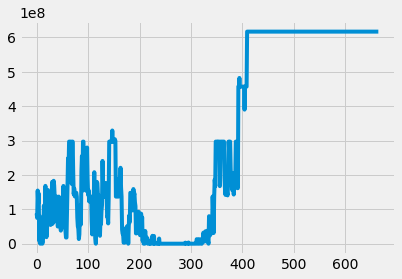

In [135]:
min_scores=[min(scores) for scores in scoress]
import matplotlib.pyplot as plt
plt.plot(range(len(min_scores)),min_scores)

In [125]:
gen_tour

[[15, 1, 1, 7, 25, 1, 38, 1, 24, 1, 27, 28, 1, 1, 50, 1, 22, 21, 47, 1],
 [29, 30, 1, 9, 60, 40, 16, 58, 11, 31, 46, 43, 52, 13],
 [17, 51, 45, 1, 2, 48, 60, 44, 54, 26, 1, 5],
 [36, 32, 60, 35, 1, 20],
 [33, 1, 42, 52, 37, 60, 4, 23, 8, 1, 1, 19, 12, 1],
 [41, 1, 1, 10, 39, 1, 18, 14, 1, 49, 59, 3, 34, 6]]

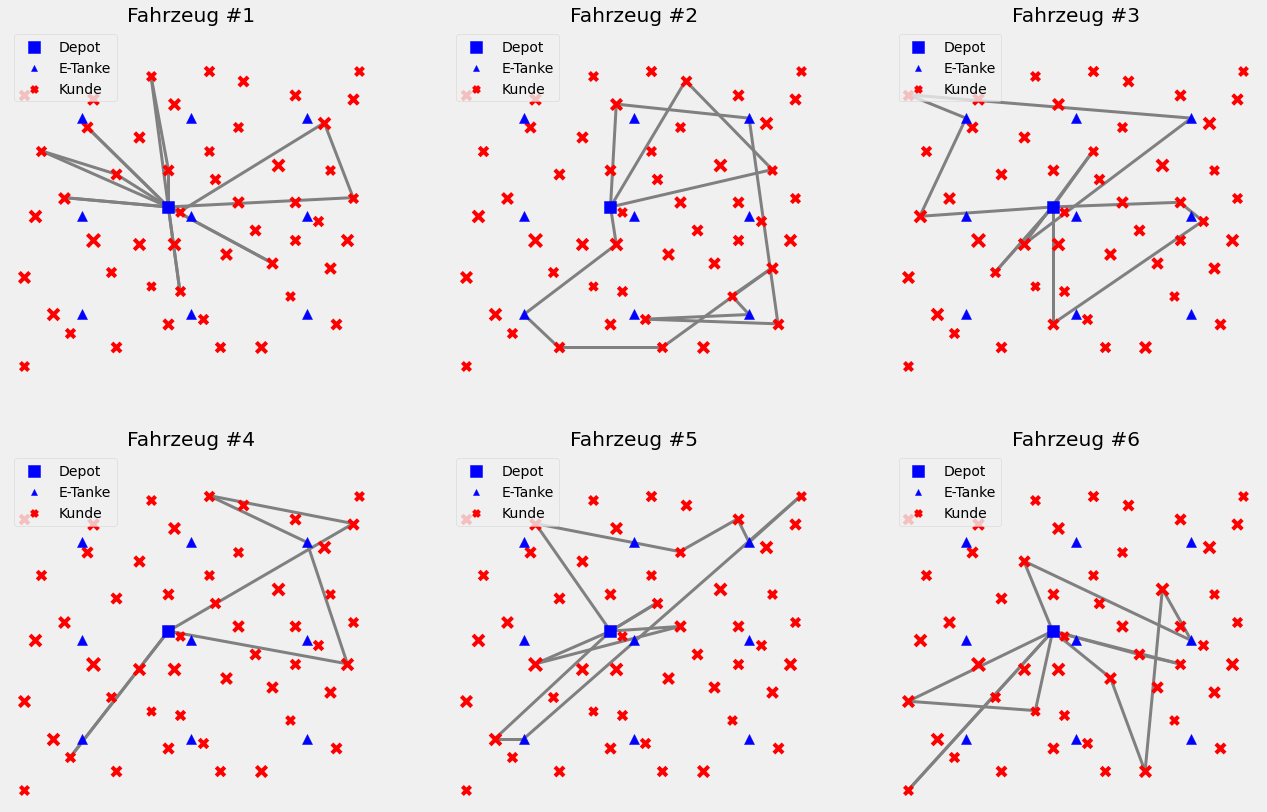

In [126]:
evrp.show(inst,tour=gen_tour)

In [129]:
population=compute_initial_population(inst,10)
for p in population:
    print(len(evrp.tour_vector_to_list(p)))

5
5
5
5
5
5
5
5
5
5
